# Deep Learning Project 3 - Jailbreaking Deep Models

In [221]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import random
import json
from tqdm import tqdm

## Task 1: Basics

In [2]:
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms,
    std=std_norms)
])

In [3]:
# Maps dataset labels correctly to ImageNet classes
class ImageNetMappedDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, offset=401):
        self.base = base_dataset
        self.offset = offset

    def __getitem__(self, idx):
        img, label = self.base[idx]
        return img, label + self.offset  # remap label

    def __len__(self):
        return len(self.base)

In [4]:
dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataset = ImageNetMappedDataset(dataset)

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [6]:
# Load pretrained ResNet-34
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model.eval().to(device)
pass

### Helper Functions

In [277]:
def evaluate(model, dataset):
    model.eval()
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    top1_correct, top5_correct, total = 0, 0, 0
    
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = softmax(outputs, dim=1)
            
            _, top5 = probs.topk(5, dim=1)
            top1 = top5[:, 0]
            top1_correct += (top1 == labels).sum().item()
            top5_correct += sum([label in top5[i] for i, label in enumerate(labels)])
            total += labels.size(0)
            
    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total

    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")
    
    return top1_acc, top5_acc

In [133]:
def unnormalize(img):
    mean = torch.tensor(mean_norms).view(3, 1, 1)
    std = torch.tensor(std_norms).view(3, 1, 1)
    return torch.clamp(img * std + mean, 0, 1)

In [134]:
def compare_samples(org_dataset, adversarial_dataset=None):
    idxs = random.sample(range(len(org_dataset)), 10)
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    
    for i, idx in enumerate(idxs):
        orig_img, _ = org_dataset[idx]
        orig_img = unnormalize(orig_img)
    
        # Plot
        axes[0, i].imshow(orig_img.permute(1, 2, 0))
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        if adversarial_dataset:
            adv_img, _ = adversarial_dataset[idx]
            adv_img = unnormalize(adv_img)

            axes[1, i].imshow(adv_img.permute(1, 2, 0))
            axes[1, i].set_title("Adversarial")
            axes[1, i].axis("off")
    
    plt.tight_layout()
    plt.show()

In [172]:
def similarity_check(org_dataset, adversarial_dataset):
    max_diffs = []

    for i in range(len(org_dataset)):
        orig_img, _ = org_dataset[i]
        adv_img, _ = adversarial_dataset[i]
    
        diff = torch.abs(orig_img - adv_img)
        max_diffs.append(diff.max().item())
        
    max_diff = max(max_diffs)
    max_diff_avg = max_diff / len(max_diffs)
    per_pixel_avg_diff = sum(max_diffs) / len(max_diffs)
    
    print(f"Max difference over dataset: {max_diff:.4f}")
    print(f"Mean max difference per image: {max_diff_avg:.4f}")
    print(f"Mean per-pixel diff: {per_pixel_avg_diff:.4f}")

    return max_diff, max_diff_avg, per_pixel_avg_diff

### Test Helper Functions on Original Data

In [148]:
# Original vs original: 0 because they are the same
similarity_check(dataset, dataset)

Max difference over dataset: 0.0000
Mean max difference per image: 0.0000
Mean per-pixel diff: 0.0000


(0.0, 0.0, 0.0)

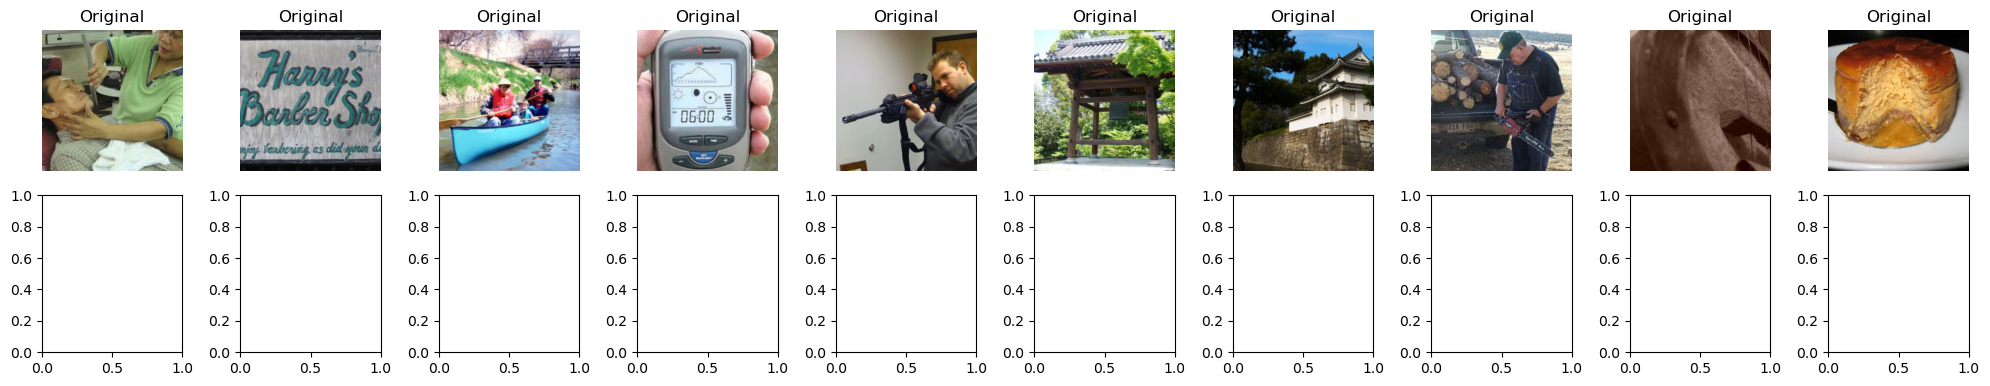

In [143]:
# Randomly sample images from original dataset
compare_samples(dataset)

### Original Accuracies

In [154]:
top1_acc, top5_acc = evaluate(pretrained_model, dataset)
baseline_acc = top1_acc, top5_acc

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]

Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.00%


## Task 2:  Pixel-wise attacks

In [243]:
def fgsm_attack(model, image, label, epsilon=0.02):
    model.eval().to(device)
    image = image.clone().to(device).detach().requires_grad_(True)
    label = label.to(device)

    output = model(image)
    loss = torch.nn.functional.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()

    perturbation = epsilon * image.grad.sign()
    adv_image = image + perturbation    
    return adv_image.detach()

In [244]:
adv_images = []
adv_labels = []

for idx in tqdm(range(len(dataset))):
    img, label = dataset[idx]
    img = img.unsqueeze(0)
    label_tensor = torch.tensor([label])

    adv_img = fgsm_attack(pretrained_model, img, label_tensor, epsilon=0.02)
    adv_images.append(adv_img.squeeze(0).detach().cpu())
    adv_labels.append(label)

adversarial_test_set_1 = TensorDataset(torch.stack(adv_images), torch.tensor(adv_labels))

top1_acc, top5_acc = evaluate(pretrained_model, adversarial_test_set_1)
task_1_acc = top1_acc, top5_acc

print("\nAccuracy Drop from Baseline")
print(f"Top-1: {baseline_acc[0] - task_1_acc[0]}%")
print(f"Top-5: {baseline_acc[1] - task_1_acc[1]}%")

similarity_check(dataset, adversarial_test_set_1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.52it/s]


Top-1 Accuracy: 6.80%
Top-5 Accuracy: 35.60%

Accuracy Drop from Baseline
Top-1: 69.2%
Top-5: 58.4%
Max difference over dataset: 0.0200
Mean max difference per image: 0.0000
Mean per-pixel diff: 0.0200


(0.020000100135803223, 4.0000200271606444e-05, 0.020000097692012785)

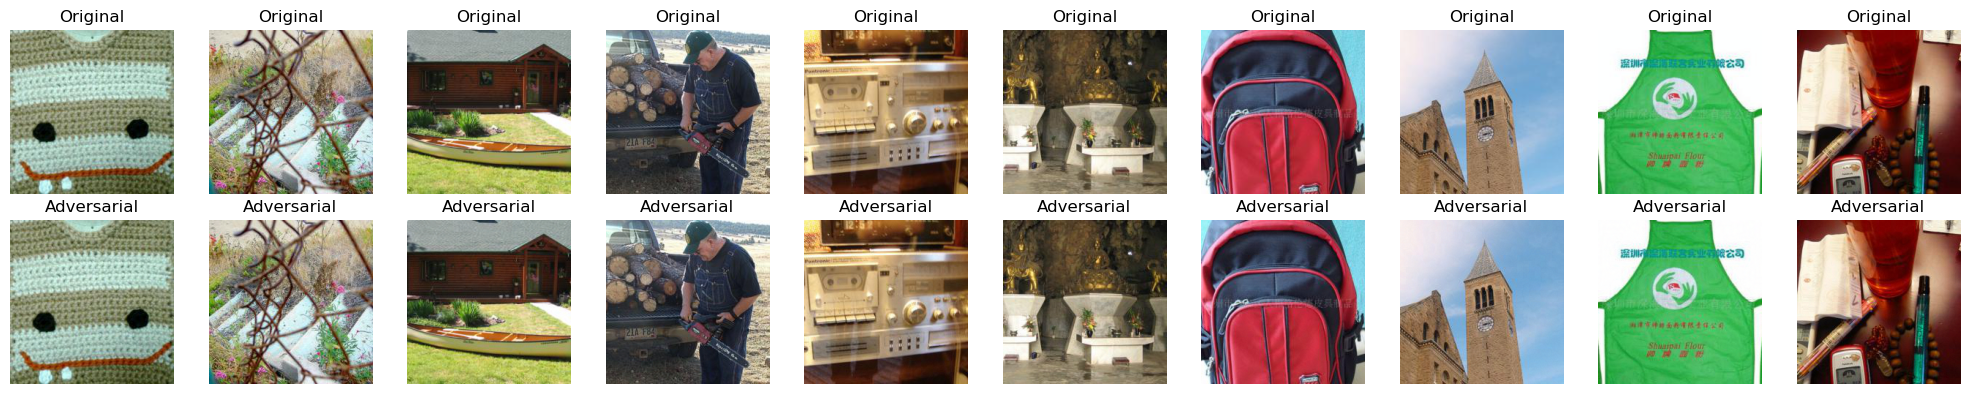

In [164]:
# compare original vs adversarial_test_set_1
compare_samples(dataset, adversarial_test_set_1)

## Task 3: Improved attacks

### Multiple Gradient Steps / Iterative FSGM
This is basically PGD without the random start

In [255]:
def iterative_fgsm(model, image, label, epsilon=0.02, alpha=0.002, steps=10):
    model.eval().to(device)
    ori_image = image.clone().detach().to(device)
    image = ori_image.clone().detach().requires_grad_(True)
    label = label.to(device)

    for _ in range(steps):
        output = model(image)
        loss = torch.nn.functional.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()

        # change image based on grad by 
        image = image + alpha * image.grad.sign()
        # clip to epsilon so it maintains diff of epsilon
        image = torch.clip(image, ori_image - epsilon, ori_image + epsilon)
        image = image.detach().requires_grad_(True)

    return image.detach()

#### Experimenting with different steps and alpha
`steps = 10` and `alpha = 0.002` gives `top 1 = 0.02%` and `top 5 = 12.40%` \
`steps = 15` and `alpha = 0.004` gives `top 1 = 0.00%` and `top 5 = 9.00%` \
`steps = 15` and `alpha = 0.006` gives `top 1 = 0.00%` and `top 5 = 9.60%`

In [256]:
adv_images = []
adv_labels = []

for idx in tqdm(range(len(dataset))):
    img, label = dataset[idx]
    img = img.unsqueeze(0)
    label_tensor = torch.tensor([label])

    epsilon = 0.02
    steps = 15
    alpha = 0.004
    
    adv_img = iterative_fgsm(pretrained_model, img, label_tensor, epsilon=epsilon, alpha=alpha, steps=steps)
    adv_images.append(adv_img.squeeze(0).detach().cpu())
    adv_labels.append(label)

adversarial_test_set_2 = TensorDataset(torch.stack(adv_images), torch.tensor(adv_labels))

top1_acc, top5_acc = evaluate(pretrained_model, adversarial_test_set_2)
task_2_acc = top1_acc, top5_acc

print("\nAccuracy Drop from Baseline")
print(f"Top-1: {baseline_acc[0] - task_2_acc[0]}%")
print(f"Top-5: {baseline_acc[1] - task_2_acc[1]}%")

similarity_check(dataset, adversarial_test_set_2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.34it/s]


Top-1 Accuracy: 0.00%
Top-5 Accuracy: 9.00%

Accuracy Drop from Baseline
Top-1: 76.0%
Top-5: 85.0%
Max difference over dataset: 0.0200
Mean max difference per image: 0.0000
Mean per-pixel diff: 0.0200


(0.020000100135803223, 4.0000200271606444e-05, 0.020000097513198853)

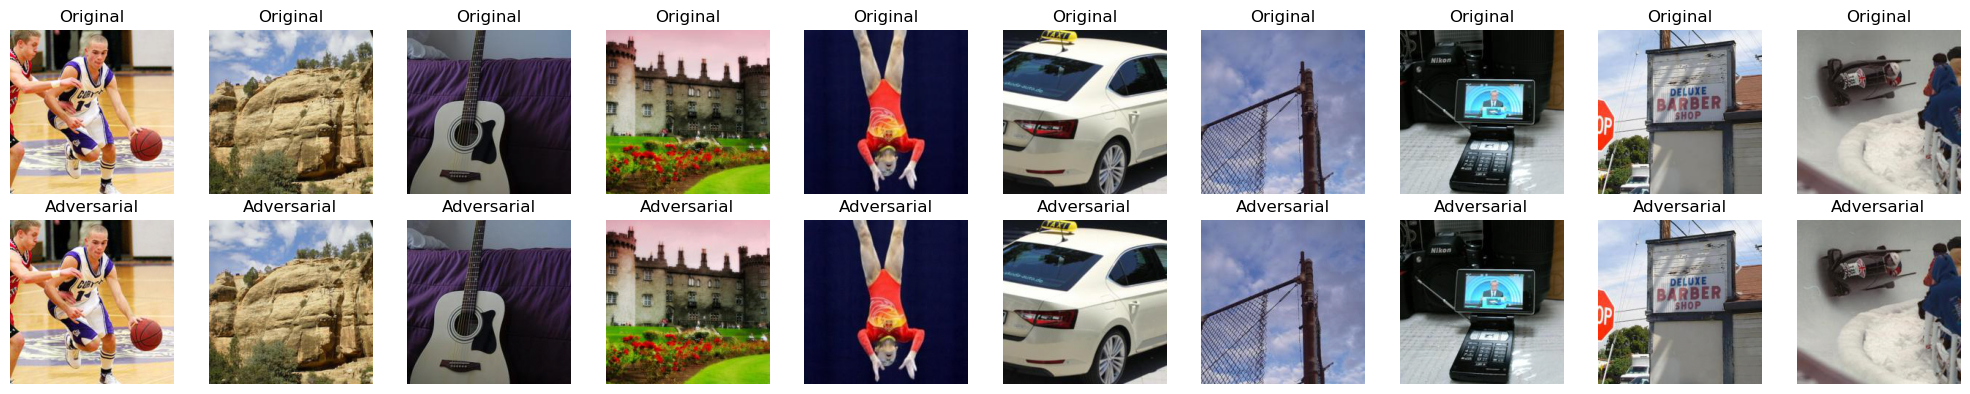

In [257]:
compare_samples(dataset, adversarial_test_set_2)

### Targeted FGSM

In [239]:
# pick a random label to target which is not the correct label
def get_random_target(label, min_label=401, max_label=500):
    target = random.randint(min_label, max_label)
    while target == label:
        target = random.randint(min_label, max_label)
    return target

In [240]:
def targeted_fgsm(model, image, target_label, epsilon=0.02):
    image = image.clone().detach().to(device).requires_grad_(True)
    target_label = target_label.to(device)

    output = model(image)
    loss = torch.nn.functional.cross_entropy(output, target_label)
    model.zero_grad()
    loss.backward()

    # negative for targeted
    # we want to minimize loss for the wrong class 
    perturbation = -epsilon * image.grad.sign()
    adv_image = image + perturbation
    return adv_image.detach()

In [245]:
adv_images = []
adv_labels = []

for idx in tqdm(range(len(dataset))):
    img, label = dataset[idx]
    img = img.unsqueeze(0)
    targeted_label = get_random_target(label)
    targeted_label_tensor = torch.tensor([targeted_label])

    adv_img = targeted_fgsm(pretrained_model, img, targeted_label_tensor, epsilon=0.02)
    adv_images.append(adv_img.squeeze(0).detach().cpu())
    adv_labels.append(label)

adversarial_test_set_2 = TensorDataset(torch.stack(adv_images), torch.tensor(adv_labels))

top1_acc, top5_acc = evaluate(pretrained_model, adversarial_test_set_2)
task_2_acc = top1_acc, top5_acc

print("\nAccuracy Drop from Baseline")
print(f"Top-1: {baseline_acc[0] - task_2_acc[0]}%")
print(f"Top-5: {baseline_acc[1] - task_2_acc[1]}%")

similarity_check(dataset, adversarial_test_set_2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.29it/s]


Top-1 Accuracy: 18.80%
Top-5 Accuracy: 43.20%

Accuracy Drop from Baseline
Top-1: 57.2%
Top-5: 50.8%
Max difference over dataset: 0.0200
Mean max difference per image: 0.0000
Mean per-pixel diff: 0.0200


(0.020000100135803223, 4.0000200271606444e-05, 0.020000097811222077)

#### Comments
Worse than regular FSGM

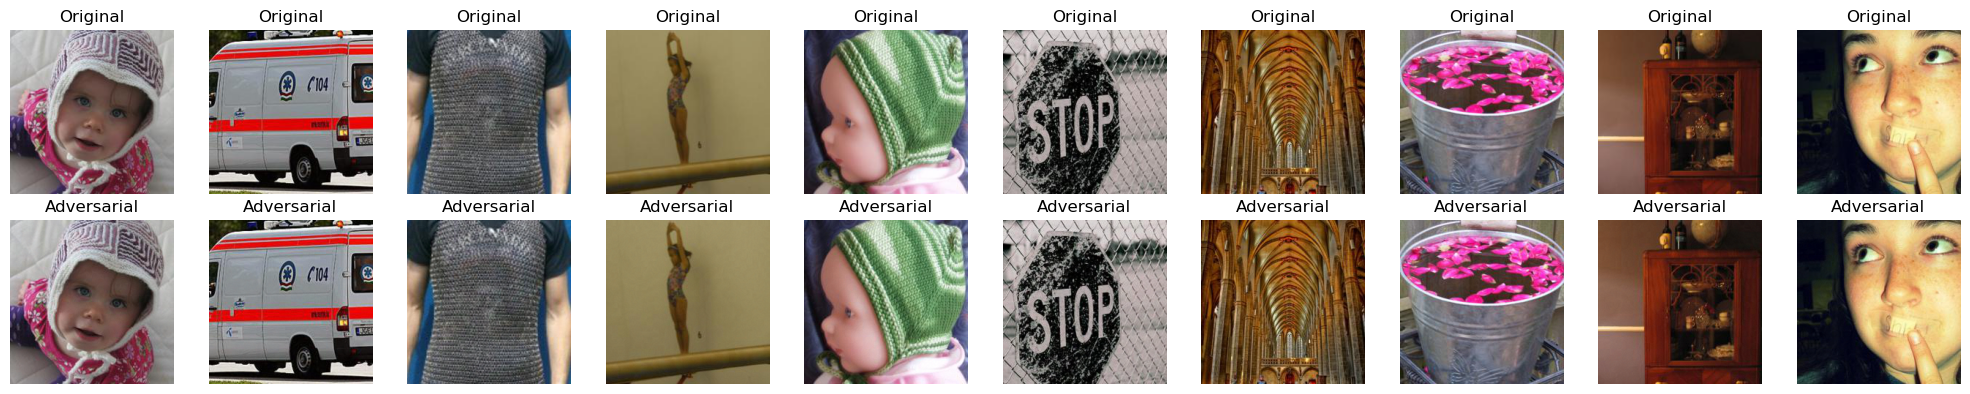

In [242]:
compare_samples(dataset, adversarial_test_set_2)

### Iterative + Targeted FGSM

In [247]:
def iterative_targeted_fgsm(model, image, target_label, epsilon=0.02, alpha=0.002, steps=10):
    model.eval().to(device)
    ori_image = image.clone().detach().to(device)
    image = ori_image.clone().detach().requires_grad_(True)
    target_label = target_label.to(device)

    for _ in range(steps):
        output = model(image)
        loss = torch.nn.functional.cross_entropy(output, target_label)
        model.zero_grad()
        loss.backward()

        # change image based on grad
        # negative because targeted
        image = image - alpha * image.grad.sign()
        # clip to epsilon so it maintains diff of epsilon
        image = torch.clip(image, ori_image - epsilon, ori_image + epsilon)
        image = image.detach().requires_grad_(True)

    return image.detach()

In [251]:
adv_images = []
adv_labels = []

for idx in tqdm(range(len(dataset))):
    img, label = dataset[idx]
    img = img.unsqueeze(0)
    targeted_label = get_random_target(label)
    targeted_label_tensor = torch.tensor([targeted_label])


    epsilon = 0.02
    steps = 20
    alpha = 0.004
    
    adv_img = iterative_targeted_fgsm(pretrained_model, img, targeted_label_tensor, epsilon=epsilon, alpha=alpha, steps=steps)
    adv_images.append(adv_img.squeeze(0).detach().cpu())
    adv_labels.append(label)

adversarial_test_set_2 = TensorDataset(torch.stack(adv_images), torch.tensor(adv_labels))

top1_acc, top5_acc = evaluate(pretrained_model, adversarial_test_set_2)
task_2_acc = top1_acc, top5_acc

print("\nAccuracy Drop from Baseline")
print(f"Top-1: {baseline_acc[0] - task_2_acc[0]}%")
print(f"Top-5: {baseline_acc[1] - task_2_acc[1]}%")

similarity_check(dataset, adversarial_test_set_2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.38it/s]


Top-1 Accuracy: 3.00%
Top-5 Accuracy: 29.80%

Accuracy Drop from Baseline
Top-1: 73.0%
Top-5: 64.2%
Max difference over dataset: 0.0200
Mean max difference per image: 0.0000
Mean per-pixel diff: 0.0200


(0.020000100135803223, 4.0000200271606444e-05, 0.020000097572803497)

#### Comments
This is still generally worse than non-targeted iterative FGSM. Makes sense its the trade-off for more control

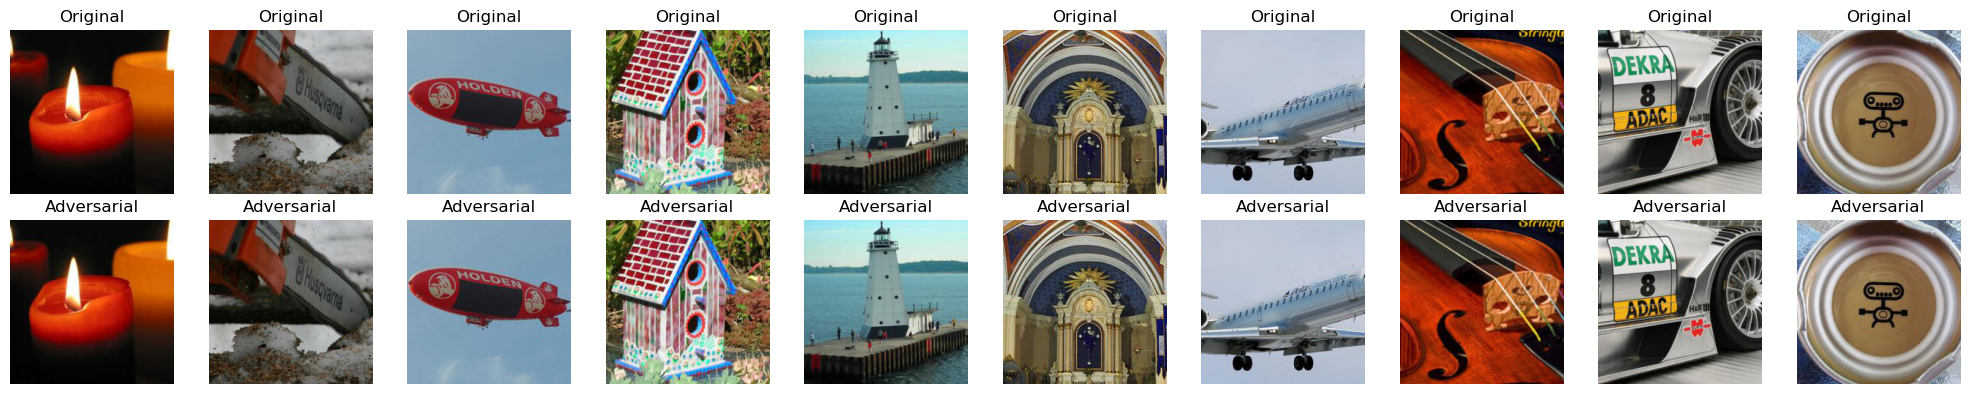

In [249]:
compare_samples(dataset, adversarial_test_set_2)

### Projected Gradient Descent (PGD)
iterative FSGM + projection/clipping + random start

In [267]:
def pgd_attack(model, image, label, epsilon=0.02, alpha=0.002, steps=10):
    model.eval().to(device)
    ori_image = image.clone().detach().to(device)
    
    # random start
    image = ori_image + torch.empty_like(ori_image).uniform_(-epsilon, epsilon)
    image = image.detach().requires_grad_(True)
    label = label.to(device)

    for _ in range(steps):
        output = model(image)
        loss = torch.nn.functional.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()

        # change image based on grad by 
        image = image + alpha * image.grad.sign()
        # clip to epsilon so it maintains diff of epsilon
        image = torch.clip(image, ori_image - epsilon, ori_image + epsilon)
        image = image.detach().requires_grad_(True)

    return image.detach()

In [268]:
adv_images = []
adv_labels = []

for idx in tqdm(range(len(dataset))):
    img, label = dataset[idx]
    img = img.unsqueeze(0)
    label_tensor = torch.tensor([label])

    epsilon = 0.02
    steps = 20
    alpha = 0.004
    
    adv_img = pgd_attack(pretrained_model, img, label_tensor, epsilon=epsilon, alpha=alpha, steps=steps)
    adv_images.append(adv_img.squeeze(0).detach().cpu())
    adv_labels.append(label)

adversarial_test_set_2 = TensorDataset(torch.stack(adv_images), torch.tensor(adv_labels))

top1_acc, top5_acc = evaluate(pretrained_model, adversarial_test_set_2)
task_2_acc = top1_acc, top5_acc

print("\nAccuracy Drop from Baseline")
print(f"Top-1: {baseline_acc[0] - task_2_acc[0]}%")
print(f"Top-5: {baseline_acc[1] - task_2_acc[1]}%")

similarity_check(dataset, adversarial_test_set_2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.00it/s]


Top-1 Accuracy: 0.00%
Top-5 Accuracy: 9.40%

Accuracy Drop from Baseline
Top-1: 76.0%
Top-5: 84.6%
Max difference over dataset: 0.0200
Mean max difference per image: 0.0000
Mean per-pixel diff: 0.0200


(0.020000100135803223, 4.0000200271606444e-05, 0.02000009745359421)

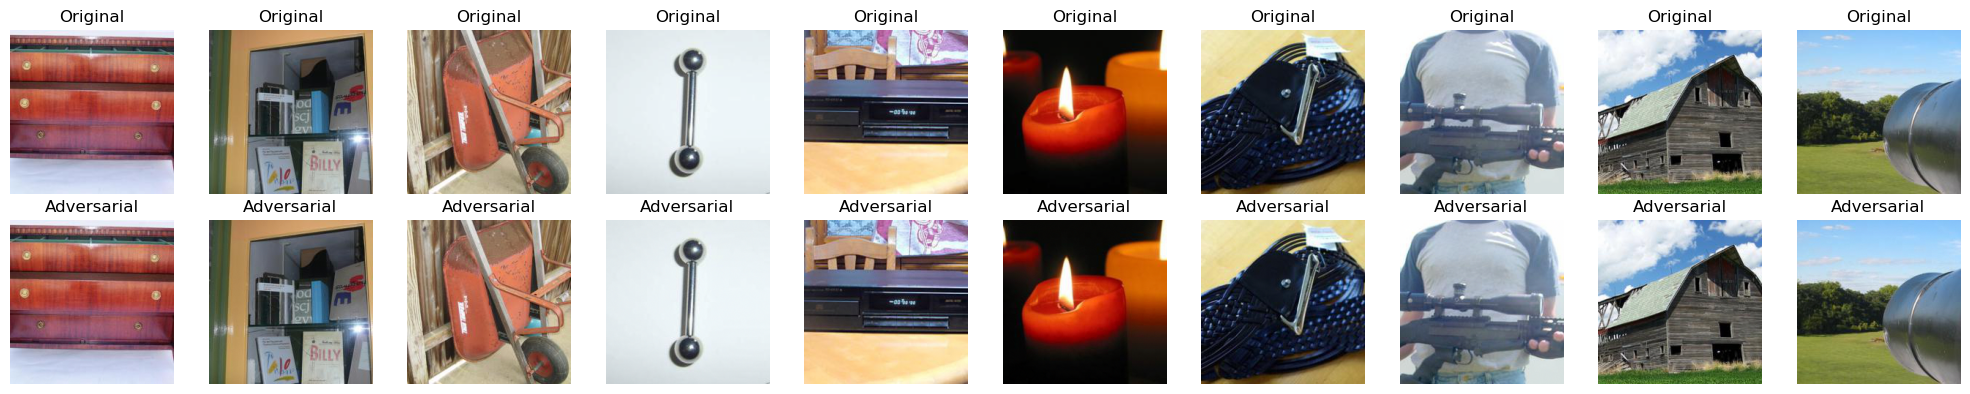

In [261]:
compare_samples(dataset, adversarial_test_set_2)

### Other Optimizers

In [266]:
# adversarial_test_set_2 = dataset

## Task 4: Patch attacks

In [ ]:
adversarial_test_set_3 = dataset

## Task 5: Transferring attacks

In [280]:
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device)

In [284]:
new_baseline_acc = evaluate(new_model, dataset)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.97it/s]

Top-1 Accuracy: 75.40%
Top-5 Accuracy: 93.60%


In [286]:
new_task_1_acc = evaluate(new_model, adversarial_test_set_1)
print("\nAccuracy Drop from Baseline")
print(f"Top-1: {new_baseline_acc[0] - new_task_1_acc[0]}%")
print(f"Top-5: {new_baseline_acc[1] - new_task_1_acc[1]}%")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.91it/s]

Top-1 Accuracy: 63.60%
Top-5 Accuracy: 88.80%

Accuracy Drop from Baseline
Top-1: 11.800000000000004%
Top-5: 4.799999999999997%


In [288]:
new_task_2_acc = evaluate(new_model, adversarial_test_set_2)
print("\nAccuracy Drop from Baseline")
print(f"Top-1: {new_baseline_acc[0] - new_task_2_acc[0]}%")
print(f"Top-5: {new_baseline_acc[1] - new_task_2_acc[1]}%")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.60it/s]

Top-1 Accuracy: 64.60%
Top-5 Accuracy: 90.40%

Accuracy Drop from Baseline
Top-1: 10.800000000000011%
Top-5: 3.1999999999999886%


In [ ]:
# new_task_3_acc = evaluate(new_model, adversarial_test_set_3)
# print("\nAccuracy Drop from Baseline")
# print(f"Top-1: {new_baseline_acc[0] - new_task_3_acc[0]}%")
# print(f"Top-5: {new_baseline_acc[1] - new_task_3_acc[1]}%")